<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
    
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 

<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.




<p></p><p></p><p></p>





**Le problème posé :**

# <font color='blus'>Indexation d'images</font>

Vous êtes bénévole pour l'association de protection des animaux de votre quartier. C'est d'ailleurs ainsi que vous avez trouvé votre compagnon idéal, Snooky. Du coup, vous vous demandez ce que vous pouvez faire en retour pour aider l'association.

Vous apprenez, en discutant avec un bénévole, que leur base de données de pensionnaires commence à s'agrandir et qu'ils n'ont pas toujours le temps de référencer les images des animaux qu'ils ont accumulées depuis plusieurs années. Ils aimeraient donc réaliser un index de l’ensemble de la base de données d’images qu’ils possèdent, pour classer les chiens par races.

**<font color='blus'>Les données</font>**

Les bénévoles de l'association n'ont pas eu le temps de réunir les différentes images des pensionnaires dispersées sur leurs disques durs. Pas de problème, vous développerez un algorithme en utilisant le Stanford Dogs Dataset pour entraîner votre algorithme.

**<font color='blus'>Votre mission</font>**

En tant que Data Scientist, l'association vous demande de réaliser un algorithme de détection de la race du chien sur une photo, afin d'accélérer leur travail d’indexation.

**<font color='blus'>Contraintes</font>**

Lors de ce projet, vous mettrez en œuvre deux approches.

* Une approche classique : il s’agit de pre-processer des images avec des techniques spécifiques (e.g.whitening, equalisation, filtre linéaire/laplacien/gaussien, éventuellement modifier la taille des images), puis d’extraire des features (e.g. texture, corners, edges et SIFT detector). Il faut ensuite réduire les dimensions, soit par des approches classiques (e.g. PCA, k-means) soit avec une approche par histogrammes et dictionary learning (bag-of-words appliqué aux images), puis appliquer des algorithmes de classification standards.



* Lors de l’analyse exploratoire, vous regarderez si les features extraites et utilisées en classification sont prometteuses en utilisant des méthodes de réduction de dimension pour visualiser le dataset en 2D. Cela vous permettra d’affiner votre intuition sur les différents traitements possibles, sans que cela ne se substitue à des mesures de performances rigoureuses.



* Une approche s’appuyant sur l’état de l’art et l’utilisation de CNN (réseaux de neurones convolutionnels). Compte tenu de la taille et de la complexité du dataset, et de la puissance de calcul à votre disposition, il est très difficile d’obtenir de bonnes performances (pour ça, essayez MNIST). Aussi, est-il recommandé d’utiliser le transfer learning, c’est-à-dire utiliser un réseau déjà entraîné, et le modifier pour répondre à votre problème. Une première chose obligatoire est de ré-entraîner les dernières couches pour prédire les classes qui vous intéressent seulement. Il est également possible d’adapter la structure (supprimer certaines couches par exemple) ou de ré-entraîner le modèle avec un très faible learning rate pour ajuster les poids à votre problème (plus long) et optimiser les performances.


***Ce notebook est dédié à la conception et à l'étude d'un CNN pré-entraîné en full tuning***

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# <font color='blus'>0. Data is loaded  </font>

In [2]:
import p5_util

filename = './data/dict_keras_dataset.dump'
dict_keras_dataset = p5_util.object_load(filename)
(X_train, X_test, y_train, y_test, nClass) = dict_keras_dataset['payload']
nClasses = y_train.shape[1]
print("Nb of breeds= "+str(nClasses))
X_train.shape, X_test.shape, y_train.shape, y_test.shape

p5_util.object_load : fileName= ./data/dict_keras_dataset.dump
Nb of breeds= 3


((322, 224, 224, 3), (139, 224, 224, 3), (322, 3), (139, 3))

#### VGG16 model is downloaded with imagenet weights without dense layers

In [3]:
from keras.applications import VGG16
 
vgg16_pretrained_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))


vgg16_pretrained_conv.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

#### Classification layers are added

In [4]:
import numpy as np

from keras import models
from keras import layers
from keras import optimizers

vgg16_imagenet_pretrained = models.Sequential()

#--------------------------------------------------------------------------
# Convolutional layers are added to the model
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(vgg16_pretrained_conv)


#--------------------------------------------------------------------------
# Flatten transformation is added in-between of output of convolutional 
# layers and of input of classification layers .
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Flatten())

#--------------------------------------------------------------------------
# Get output dimensions from convolutional layer
#--------------------------------------------------------------------------
conv_layer_output_shape = np.prod(vgg16_imagenet_pretrained.output_shape[1:])
conv_layer_output_shape

#--------------------------------------------------------------------------
# Fist dense layer is compliant with output of last convolutional layer 
# from pre-trained model for transfer learning
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Dense(512, activation='relu', input_dim=conv_layer_output_shape))
vgg16_imagenet_pretrained.add(layers.Dropout(0.5))

#--------------------------------------------------------------------------
# Last dense layer will classify amont nClass classes.
#--------------------------------------------------------------------------
vgg16_imagenet_pretrained.add(layers.Dense(nClasses, activation='softmax'))


vgg16_imagenet_pretrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 27,561,795
Non-trainable params: 0
_________________________________________________________________


#### Compilation

In [5]:
vgg16_imagenet_pretrained.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=0.0001\
                                                             , momentum=0.9), metrics=["accuracy"])
vgg16_imagenet_pretrained.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 27,561,795
Non-trainable params: 0
_________________________________________________________________


#### Model is trained with previous features extracted from convolutional layers.

In [6]:
history = vgg16_imagenet_pretrained.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=100,
                    validation_data=(X_test,y_test))


Train on 322 samples, validate on 139 samples
Epoch 1/50
322/322 [==============================] - 126s 391ms/step - loss: 1.6498 - acc: 0.2702 - val_loss: 1.1615 - val_acc: 0.3022
Epoch 2/50
322/322 [==============================] - 287s 891ms/step - loss: 1.4193 - acc: 0.3323 - val_loss: 1.3055 - val_acc: 0.3094
Epoch 3/50
322/322 [==============================] - 219s 681ms/step - loss: 1.2710 - acc: 0.4099 - val_loss: 1.0383 - val_acc: 0.4532
Epoch 4/50
322/322 [==============================] - 175s 544ms/step - loss: 1.1661 - acc: 0.3851 - val_loss: 1.0363 - val_acc: 0.4317
Epoch 5/50
322/322 [==============================] - 155s 481ms/step - loss: 1.1006 - acc: 0.3975 - val_loss: 1.0035 - val_acc: 0.5108
Epoch 6/50
322/322 [==============================] - 144s 447ms/step - loss: 1.0485 - acc: 0.4658 - val_loss: 1.0355 - val_acc: 0.4964
Epoch 7/50
322/322 [==============================] - 132s 410ms/step - loss: 1.0663 - acc: 0.4627 - val_loss: 0.9588 - val_acc: 0.5612
Ep

#### Results are displayed

139/139 [==============================] - 15s 105ms/step
Evaluation result on Test Data : Loss = 0.53, accuracy = 0.79


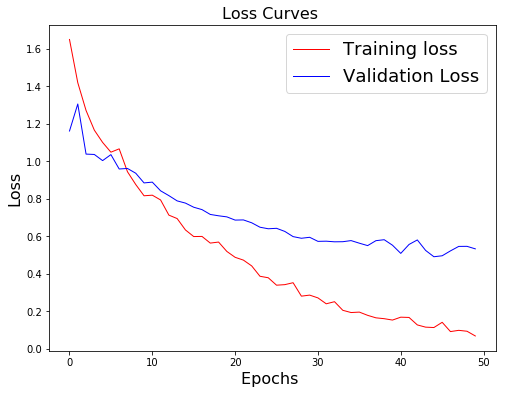

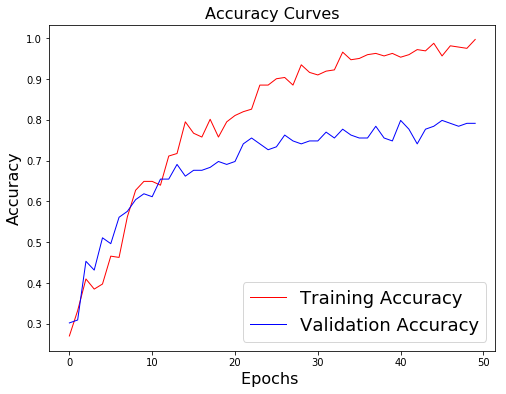

In [8]:
import p7_util

lost, score_acc = p7_util.p7_plot_cnn_history(vgg16_imagenet_pretrained, X_test, y_test, history=history)